# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/110d62ce29265af908ef9ed46becc24ab9d2fc985c410bdc646e9815.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **West Haven, Connecticut, United States**, and the stations the data comes from are shown on the map below.

In [2]:
%matplotlib notebook

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
import mplleaflet
import pandas as pd

In [8]:
def process_weather():
    # read CSV file
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/110d62ce29265af908ef9ed46becc24ab9d2fc985c410bdc646e9815.csv',parse_dates=['Date'])

    # several tasks to do: 1 strip leap days, 2 compute lowest/highest 2005-2014 values
    # strip leap days
    #df=df[(df['Date'] != '2008-02-29') & (df['Date'] != '2012-02-29')]
    
    df['day_of_year']=df['Date'].dt.dayofyear # so, this is basically Julian

    # I'm pretty upset about the leap years. The instructions suggest pulling them out.
    # I think, to do that, you would subtract one from the result here, if the year is he leap year, and it's past 2/28
    # I'm not sure that is actually the right thing to do. 
    # Wow. I'm actually super conflicted about this.
    
    #df.index=df['day_of_year']
    
    # This is our "primary" period for the line
    df_reference = df[(df['Date'] > '2004') & (df['Date'] < '2015')]
    
    # split this, could probably pivot instead. I tried it, then gave up. Learn that later.
    df_max_set = df_reference[df_reference['Element'] == 'TMAX']
    df_min_set = df_reference[df_reference['Element'] == 'TMIN']
    
    df_ref_max = df_max_set.groupby(['day_of_year'])['Data_Value'].max()
    df_ref_min = df_min_set.groupby(['day_of_year'])['Data_Value'].min()

    # This is the scatter period. Basically do it all again. I feel dirty. Must be a better way.
    df_test = df[(df['Date'] > '2014') & (df['Date'] < '2016')]

    df_max_set = df_test[df_test['Element'] == 'TMAX']
    df_min_set = df_test[df_test['Element'] == 'TMIN']
    
    df_test_max = df_max_set.groupby(['day_of_year'])['Data_Value'].max()
    df_test_min = df_min_set.groupby(['day_of_year'])['Data_Value'].min()
    
    # now, combine this into something useful
    df_result = pd.concat([df_ref_max, df_ref_min,df_test_max,df_test_min], axis=1)
    df_result.columns = ['Ref_Max','Ref_Min','Test_Max','Test_Min']

    # get rid of this awful extra day
    df_result = df_result[0:365]
    
    # this should make it easier to filter for the scatter
    df_result['Test_Max_Break'] = df_result.apply(lambda x: x['Test_Max'] > x['Ref_Max'], axis=1)
    df_result['Test_Min_Break'] = df_result.apply(lambda x: x['Test_Min'] < x['Ref_Min'], axis=1)

    return(df_result)

<IPython.core.display.Javascript object>


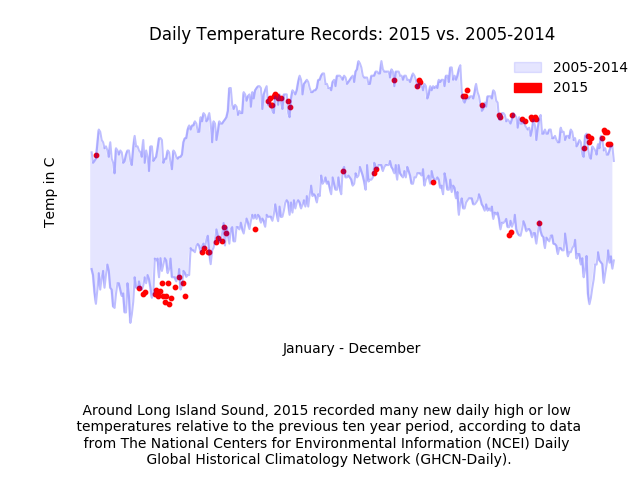

In [52]:
def make_plots():
    # fetch data
    df = process_weather()
    df_2015_max = df[df['Test_Max_Break']]
    df_2015_min = df[df['Test_Min_Break']]
    
    fig = plt.figure(frameon=False)
    
    plt.gca().set_position((.1, .3, .9, .6)) # to make a bit of room for extra text
    
    # associate fig with the backend
    canvas = FigureCanvasAgg(fig)

    #Scatter
    plt.scatter(df_2015_max.index,df_2015_max['Test_Max'], s=10, c='red', label='2015')
    plt.scatter(df_2015_min.index,df_2015_min['Test_Min'], s=10, c='red', label='_2015')
    
    #Line Plot
    plt.plot(df['Ref_Max'], '-', df['Ref_Min'], '-',c='blue', alpha=0.25, label='2005-2014')
    
    #Labels
    plt.xlabel('January - December')
    plt.ylabel('Temp in C')
    plt.title('Daily Temperature Records: 2015 vs. 2005-2014')
    
    # add a legend with legend entries (because we didn't have labels when we plotted the data series)
    #plt.legend(labels = ['2015','2005-2014'], frameon=False)
    blue_patch = mpatches.Patch(color='blue', label='2005-2014', alpha=0.10)
    red_patch = mpatches.Patch(color='red', label='2015')
    
    plt.legend(handles=[blue_patch,red_patch], frameon=False)

    plt.gca().fill_between(range(len(df['Ref_Max'])), 
                       df['Ref_Max'], df['Ref_Min'], 
                       facecolor='blue', 
                       alpha=0.10)

    # add a caption
    txt = '''
    Around Long Island Sound, 2015 recorded many new daily high or low 
    temperatures relative to the previous ten year period, according to data
    from The National Centers for Environmental Information (NCEI) Daily 
    Global Historical Climatology Network (GHCN-Daily).
    '''
    plt.figtext(0.5,0,txt,ha='center')
    
    #OK start ripping off junk

    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        right='off',
        labelleft='off',
        labelbottom='off') # labels along the bottom edge are off

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    canvas.print_png('rawling_week2_2.png')
        
make_plots()

In [53]:
%%html
<img src='rawling_week2_2.png' />